In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's load in the drivers, results and races data as these will be what we use to make the parallel plot.

In [2]:
drivers = pd.read_csv('./data/drivers.csv')
drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [3]:
results = pd.read_csv('./data/results.csv')
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [4]:
races = pd.read_csv('./data/races.csv')
races.head()

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


To avoid plotting data for too many drivers, I want to plot only for the drivers that raced in the 2020 F1 season. To get these, we extract the races by year. We can then use the raceIds from these to filter the results for races in the 2020 season. We can then filter all of the results by the driverIds from the 2020 results. This is a little convoluted but does the job.

In [5]:
# get drivers on 2020 grid
races_2020 = races[races.year == 2020]
results_2020 = results[results.raceId.isin(races_2020.raceId.values)]
# Reduce the results dataframe to only include results involving 2020 drivers
results = results[results.driverId.isin(results_2020.driverId.unique())]
print(results.shape)
results.head()

(2669, 18)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
7,8,18,8,6,1,15,8,8,8,1.0,53,\N,\N,20,4,1:27.903,217.180,5
19,20,18,20,5,15,9,\N,R,20,0.0,0,\N,\N,\N,\N,\N,\N,4
22,23,19,8,6,1,2,1,1,1,10.0,56,1:31:18.555,5478555,37,2,1:35.405,209.158,1
26,27,19,1,1,22,9,5,5,5,4.0,56,+46.548,5525103,53,3,1:35.462,209.033,1


We can now start counting wins using the pandas groupby function with the position column. We'll run this and reduce and rename the columns.

In [6]:
wins = results[results.position == '1'].groupby(['driverId']).count().reset_index()
wins = wins[['driverId','resultId']]
wins.columns = ['driverId','wins']
wins.head()

,driverId,wins
0,1,95
1,8,21
2,20,53
3,815,1
4,817,7


Now let's do the same for the number of podiums, pole positions, fastest laps and the number of races each driver has competed in.

In [7]:
podiums = results[results.position.isin(['1','2','3'])].groupby(['driverId']).count().reset_index()
podiums = podiums[['driverId','resultId']]
podiums.columns = ['driverId','podiums']

In [8]:
num_races = results.groupby(['driverId']).count().reset_index()
num_races = num_races[['driverId','resultId']]
num_races.columns = ['driverId','races']

In [9]:
poles = results[results.grid.isin(['1'])].groupby(['driverId']).count().reset_index()
poles = poles[['driverId','resultId']]
poles.columns = ['driverId','poles']

In [10]:
fastest_lap = results[results['rank'].isin(['1'])].groupby(['driverId']).count().reset_index()
fastest_lap = fastest_lap[['driverId','resultId']]
fastest_lap.columns = ['driverId','fastest_lap']

We now need to merge all this data into one dataframe. We first edit the names so that they are one field. We can then merge the driver details with the number of races they have competed in. It's important to do the number of races first as this value is defined for all of the drivers that we are interested in. 

We can then merge in the other statistics from the above data frames, using an outer merge. This will add a NaN field for drivers that are not in the given dataframe, i.e. they haven't got a race win, or podium etc.

In [11]:
drivers['name'] = drivers.forename + " " + drivers.surname
stats = drivers[['driverId','name']].merge(num_races, on='driverId')
stats = stats.merge(podiums, on='driverId', how='outer')
stats = stats.merge(wins, on='driverId', how='outer')
stats = stats.merge(poles, on='driverId', how='outer')
stats = stats.merge(fastest_lap, on='driverId', how='outer')

We can now replace the NaN values with zeros, and convert the columns to integers (as it looks a little odd to have 10.0 podiums).

In [12]:
stats = stats.fillna(0)
stats.podiums = stats.podiums.astype(int)
stats.wins = stats.wins.astype(int)
stats.poles = stats.poles.astype(int)
stats.fastest_lap = stats.fastest_lap.astype(int)
stats

,driverId,name,races,podiums,wins,poles,fastest_lap
0,1,Lewis Hamilton,266,165,95,98,53
1,8,Kimi Räikkönen,332,103,21,18,43
2,20,Sebastian Vettel,258,121,53,57,37
3,154,Romain Grosjean,181,10,0,0,1
4,842,Pierre Gasly,64,2,1,0,2
5,807,Nico Hülkenberg,182,0,0,1,2
6,815,Sergio Pérez,193,10,1,0,4
7,817,Daniel Ricciardo,188,31,7,3,15
8,822,Valtteri Bottas,157,56,9,16,15
9,825,Kevin Magnussen,120,1,0,0,2


I am going to remove both Pietro Fittipaldi and Jack Aitken as they both have so little data (note thei

In [15]:
stats = stats.iloc[:21]
stats

,driverId,name,races,podiums,wins,poles,fastest_lap
0,1,Lewis Hamilton,266,165,95,98,53
1,8,Kimi Räikkönen,332,103,21,18,43
2,20,Sebastian Vettel,258,121,53,57,37
3,154,Romain Grosjean,181,10,0,0,1
4,842,Pierre Gasly,64,2,1,0,2
5,807,Nico Hülkenberg,182,0,0,1,2
6,815,Sergio Pérez,193,10,1,0,4
7,817,Daniel Ricciardo,188,31,7,3,15
8,822,Valtteri Bottas,157,56,9,16,15
9,825,Kevin Magnussen,120,1,0,0,2


Now, let's have a quick look at how the data looks in a parallel plot. It doesn't look great as only one y-axis is used for all of the data. This can probably be set using pandas, but as we're only looking for an idea of what the final plot might look like, and it should be easier to do this in d3, there is no need to add variable y-axes here.

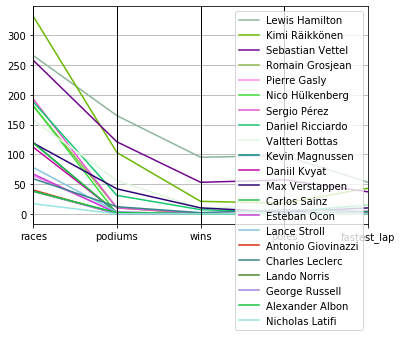

In [13]:
pd.plotting.parallel_coordinates(stats.drop(['driverId'], axis=1).iloc[:21], 'name')
plt.show()

In [14]:
stats.to_csv('./data/driver_stats.csv')